# 3. Optimization

This exercise is devoted to: 
- convex and non-convex optimization, 
- how to use different optimizer with PyTorch, and
- how to apply some common tricks of optimization

**Imports and Utils**

In [68]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler


def plot_progress(func, track, losses, func_min, torch=False):
    """
    Adapted from 
    https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/3-Pytorch-Optimizers.ipynb
    """
    # Draw the contours of the objective function, and x, and y
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    xs = np.linspace(-2.5, 2.5, 100)
    ys = np.linspace(-1, 4, 100)
    X, Y = np.meshgrid(xs, ys)
    Z = func(np.concatenate([np.expand_dims(X, 0), np.expand_dims(Y, 0)]))
    Z = np.array(Z)

    levels = np.linspace(Z.min(), Z.max(), 100)
    manual_levels = np.array([5, 20, 100])
    levels = np.concatenate(((Z.min()+0.001) * manual_levels, levels))
    levels.sort()

    ax1.contour(X, Y, Z, levels=levels, cmap="bwr", alpha=0.5)
    track = np.stack(track).T  # (2,n)

    for i in range(len(losses)-1):
        ax1.plot(track[0, i:i+2], track[1, i:i+2], marker='o',
                 color='k', alpha=0.2 + i/(len(losses)-1) * 0.3)

    ax1.scatter(func_min[0], func_min[1], s=80, c='g', marker=(5, 1))

    ax1.set_title('progress of x')
    ax1.set_ylim(-1.0, 4)
    ax1.set_xlim(-2.5, 2.5)
    ax1.set_ylabel('x_2')
    ax1.set_xlabel('x_1')

    ax2.set_title('progress of loss')
    ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    for i in range(len(losses)-1):
        ax2.plot([i, i+1], losses[i:i+2], marker='o',
                 color='k', alpha=0.2 + i/(len(losses)-1) * 0.3)

    ax2.hlines(func(func_min), 0, len(losses), colors='g')
    # ax2.plot(range(len(losses)), losses, marker='o', color='k')
    ax2.set_ylabel('objective')
    ax2.set_xlabel('iteration')
    fig.show()


## 3.1 With Analytical Derivatives

### 3.1.1 Case Study: Convex vs Non-Convex Optimization

For the convex optimization case, we look at the Rosenbrock function

$f_1(x) = (x_2-x_1^2)^2 + 0.01 \cdot (1-x_1)^2$

The non-convex case emerges if we add a sinosoidal signal in $x$, i.e. 

$f_2(x) = (x_2-x_1^2)^2 + 0.01 \cdot (1-x_1)^2 + 0.1 \cdot (1 + \cos(x_1))$

In [27]:
def f1(x):
    """Rosenbrock function
    Has one local and global minimum at f(1,1)=0"""
    return (x[1]-x[0] ** 2) ** 2 + 0.01 * (1-x[0]) ** 2


def grad_f1(x):
    """Gradient of Rosenbrock function"""
    dx0 = - 2 * (x[1] - x[0] ** 2) * 2 * x[0] - 2 * 0.01 * (1-x[0])
    dx1 = 2 * (x[1] - x[0] ** 2)
    return np.array([dx0, dx1])


def hess_f1(x):
    """Hessian of Rosenbrock function"""
    dxdx = 8*x[0]**2 - 4*(x[1]-x[0]**2) + 2*0.01
    dxdy = dydx = -4*x[0]
    dydy = 2
    return np.array([[dxdx, dxdy], [dydx, dydy]])


f1_min = np.array([1.0, 1.0])


def f2(x, use_torch=False):
    """Extended Rosenbrock function
    Has one global minimum f(0.63, 0.40)=0.00137 and many local minima"""
    regular_rosenbrock = (x[1]-x[0] ** 2) ** 2 + 0.01 * (1-x[0]) ** 2

    if use_torch:
        return regular_rosenbrock + 0.1 * (1 + torch.cos(5*x[0]))
    else:
        return regular_rosenbrock + 0.1 * (1 + np.cos(5*x[0]))


def grad_f2(x):
    """Gradient of extended Rosenbrock function"""
    dx0 = - 2 * (x[1] - x[0] ** 2) * 2 * x[0] - 2 * \
        0.01 * (1-x[0]) - 0.1 * np.sin(5*x[0]) * 5
    dx1 = 2 * (x[1] - x[0] ** 2)
    return np.array([dx0, dx1])


def hess_f2(x):
    """Hessian of extended Rosenbrock function"""
    dxdx = 8*x[0]**2 - 4*(x[1]-x[0]**2) + 2*0.01 - 0.1 * np.cos(5*x[0]) * 5 * 5
    dxdy = dydx = -4*x[0]
    dydy = 2
    return np.array([[dxdx, dxdy], [dydx, dydy]])


f2_min = np.array([0.63, 0.40])


In [28]:
selected_function = 2

if selected_function == 1:
    func = f1
    grad_func = grad_f1
    hess_func = hess_f1
    func_min = f1_min
else:
    func = f2
    grad_func = grad_f2
    hess_func = hess_f2
    func_min = f2_min


### 3.1.2 Gradient Descent (revised)

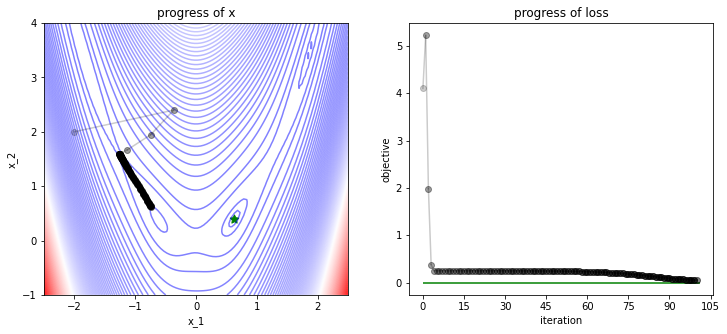

In [29]:

num_iters = 100
x = np.array([-2., 2])
track, losses = [x], [func(x)]


def gd_step(x, grad, lr=0.1):
    # GD step
    x = x - lr * grad
    return x


for iter in range(num_iters):
    # apply gradient descent
    grad = grad_func(x)
    x = gd_step(x=x, grad=grad)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.3 Gradient Descent with Momentum

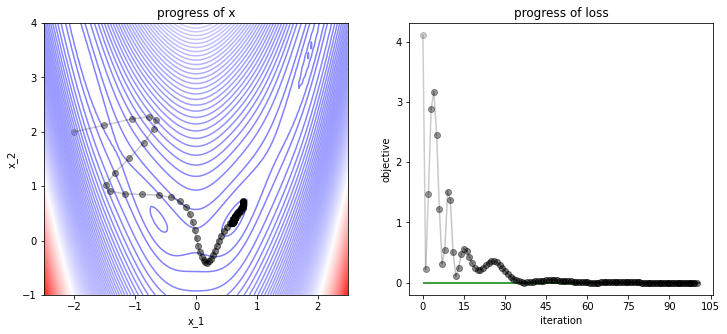

In [30]:
num_iters = 100
x = np.array([-2., 2])
v = np.zeros(x.shape)
track, losses = [x], [func(x)]


def gd_with_momentum_step(x, v, grad, lr=0.03, beta=0.9):
    # GD with momentum step
    v = beta*v + grad
    x = x - lr * v
    return (x, v)


for iter in range(num_iters):
    # apply gradient descent with momentum
    grad = grad_func(x)
    x, v = gd_with_momentum_step(x=x, v=v, grad=grad)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.4 Adam

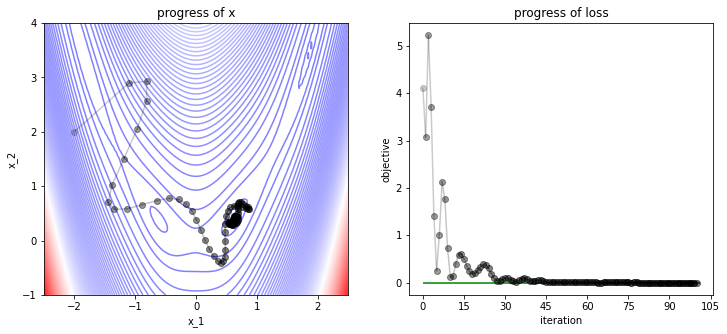

In [31]:
num_iters = 100
x = np.array([-2., 2])
v = np.zeros(x.shape)
s = np.zeros(x.shape)
track, losses = [x], [func(x)]


def adam_step(x, v, s, grad, t, lr=.9, beta1=0.9, beta2=0.999):
    # Adam step
    v = beta1 * v + (1 - beta1) * grad
    s = beta2 * s + (1 - beta2) * grad ** 2
    v_hat = v / (1 - beta1 ** t)
    s_hat = s / (1 - beta2 ** t)
    # the small number in the next line is added to avoid divisions by zero
    x = x - lr * v_hat / (np.sqrt(s_hat) + 0.0000001)
    return (x, v, s)


for iter in range(num_iters):
    # apply Adam
    grad = grad_func(x)
    x, v, s = adam_step(x=x, v=v, s=s, grad=grad, t=(iter+1))

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.5 Newton Optimizer

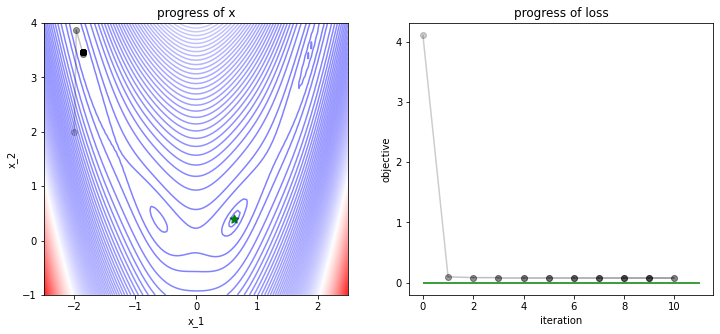

In [32]:
num_iters = 10
x = np.array([-2., 2])
track, losses = [x], [func(x)]


def newton_step(x, grad, hess, lr=1.0):
    # Newton's method step
    hess_inv = np.linalg.inv(hess)
    x = x - lr * hess_inv @ grad
    # equivalent to `x = x - lr * np.dot(hess_inv, grad)`
    return x


for iter in range(num_iters):
    # apply Newton's method
    grad = grad_func(x)
    hess = hess_func(x)

    x = newton_step(x=x, grad=grad, hess=hess)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.6 Derivative-Free Optimization

Here, we compare two very similar algorithms: Grid Search and Random Search.

We assume that we know the range of the parameters, in which the minimum is contained. We then just explore the region either in a structered way (grid search) or by random sampling (random search).

Our best guess is x=[2.], y=[3.], and loss = [1.02609285]


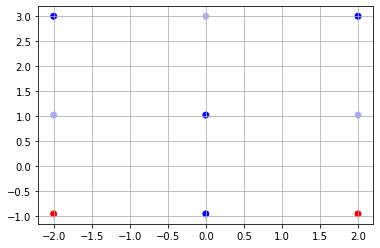

In [33]:
samples_per_dim = 3

# grid search

xs = np.linspace(-2.0, 2.0, samples_per_dim)
ys = np.linspace(-0.95, 3.0, samples_per_dim)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros(X.shape)
for i in range(len(xs)):
    for j in range(len(xs)):
        Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

plt.scatter(X.flatten(), Y.flatten(), c=Z.flatten(), cmap='bwr')
plt.grid()

idx = Z == Z.min()
print(
    f"Our best guess is x={X[idx]}, y={Y[idx]}, and loss = {func(np.array([X[idx], Y[idx]]))}")


Our best guess is x=[0.78587674], y=[0.5988642], and loss = [0.03026833]


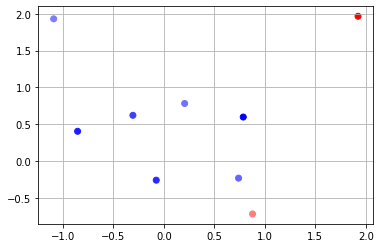

In [34]:
# random search

np.random.seed(123)
# sample randomly samples_per_dim**2 points on the x and y axis
X = np.random.uniform(-2.0, 2.0, int(samples_per_dim**2))
Y = np.random.uniform(-0.95, 3.0, int(samples_per_dim**2))
# evaluate loss at each of these points
Z = np.zeros(X.shape)
for i in range(len(Z)):
    Z[i] = func(np.array([X[i], Y[i]]))

plt.scatter(X, Y, c=Z, cmap='bwr')
plt.grid()

idx = Z == Z.min()
print(
    f"Our best guess is x={X[idx]}, y={Y[idx]}, and loss = {func(np.array([X[idx], Y[idx]]))}")


## 3.2 With PyTorch

### 3.2.2 Gradient Descent

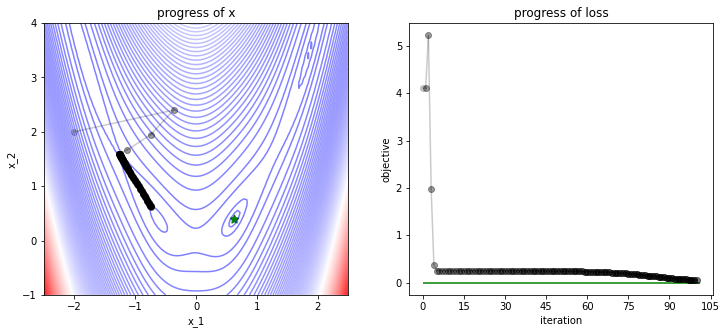

In [16]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.1)

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    loss = func(x, use_torch=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    track.append(x.detach().clone().numpy())
    losses.append(loss.detach().numpy())

plot_progress(func, track, losses, func_min)


### 3.2.3 Adam

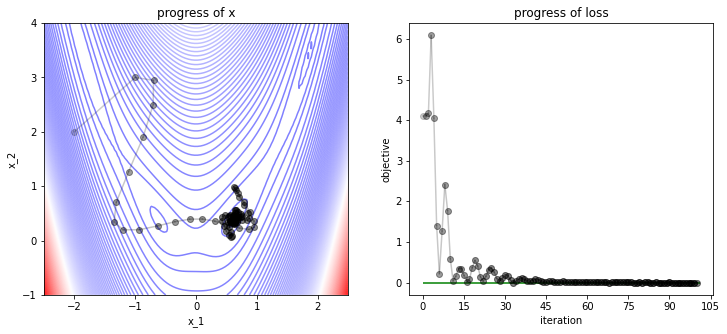

In [17]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=1.0, betas=(0.9, 0.95))

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    loss = func(x, use_torch=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    track.append(x.detach().clone().numpy())
    losses.append(loss.detach().numpy())

plot_progress(func, track, losses, func_min)


### 3.2.4 L-BFGS

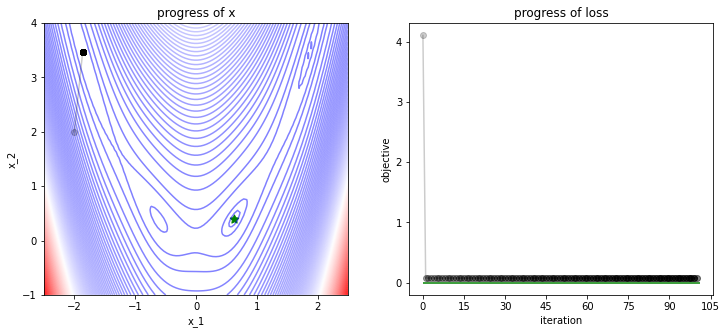

In [18]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.LBFGS([x], lr=1.0)

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    # LBFGS requres a `closure` for the approximation of the hessian
    # typically it is the gradient:
    def closure():
        """
        from the [documentation](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html): 
        "A closure that reevaluates the model and returns the loss."

        More information on the closure here:
        https://pytorch.org/docs/stable/optim.html
        """
        optimizer.zero_grad()
        loss = func(x, use_torch=True)
        loss.backward()
        return loss

    optimizer.step(closure)

    track.append(x.detach().clone().numpy())
    losses.append(func(x, use_torch=True).detach().numpy())

    optimizer.step(closure)


plot_progress(func, track, losses, func_min)


## 3.3 Tricks of Optimization)

In [79]:
# plot util

def plot_progress_polynoial(losses, model, x_data, y_data):
    # visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # left plot
    x_linspace = torch.linspace(1., 2.5, 41).unsqueeze(1)

    with torch.no_grad():
        y_pred_np = model(x_linspace).data.squeeze().numpy()

    # for plotting we transfer everything from torch to numpy
    x_data_np = x_data.detach().squeeze().numpy()
    y_data_np = y_data.detach().squeeze().numpy()
    x_np = x_linspace.squeeze().numpy()

    # plot performance
    ax1.plot(x_data_np, y_data_np, 'go', label='True data')
    ax1.plot(x_np, y_pred_np, '--', label='Predictions')
    ax1.legend()
    ax1.grid()

    # right plot
    ax2.plot(losses)
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('loss')
    ax2.grid()

    plt.show()


# train util

def train(num_iters, model, optimizer, criterion, x_data, y_data, losses, stepwise_lr=False):
    print("## Parameters before training")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)
    
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,100], gamma=0.01)

    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            loss = criterion(y_pred, y_data)
            loss.backward()
            return loss

        if stepwise_lr:
          scheduler.step(closure)

        if not stepwise:
          optimizer.step(closure)
          
        losses.append(closure().detach().item())

    # Caution: LBFGS converges very fast, but will not always converge to the 
    # true minimum. Check the left plot below to verify validity.
    print("## Parameters after training:")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)

    print(f"## Loss at the end of training = {losses[-1]}")


### 3.2.1 Case Study: Polynomial Linear Regression

> Note: we move back to the typical ML notation with measurement pairs $\left\{x^{(i)}, y^{\text {(i)}}\right\}_{i=1,...m}$, model $h(x)$ which should approximate $y$, and loss $\mathcal{L}$

In this specific case we look at polynomial linear regression, i.e.

$$
h(x) = \vartheta_0 + \vartheta_1 \cdot x^1 + ... + \vartheta_p \cdot x^p
$$

We work with a very simple artificial dataset consisting on 5 measurement pairs given below. 

In [21]:
x_data = torch.tensor([[1.0, 1.5, 1.8, 2.3, 2.5]], requires_grad=True).T
y_data = torch.tensor([[3.0, 2., 2.3, 4., 1.]], requires_grad=True).T

class DummyData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


dummy_data = DummyData(x_data, y_data)


### 3.3.1 Choice of Model Complexity

Let's first construct a linear model and set up an optimization with Adam.

In [22]:
# model

class PolynomialModel(nn.Module):
    """ from https://soham.dev/posts/polynomial-regression-pytorch"""

    def __init__(self, degree):
        super().__init__()
        self._degree = degree
        # 1 is the dimension of the output y
        self.linear = nn.Linear(self._degree, 1)

    def forward(self, x):
        return self.linear(self._polynomial_features(x))

    def _polynomial_features(self, x):
        return torch.cat([x ** i for i in range(1, self._degree + 1)], 1)


**Exercise**

Try various values for the degree of the polynomial. When does overfitting begin? 

> Keep in mind: polynomial with degree `d` is able to perfectly fit `d+1` points


## Parameters before training
linear.weight :  tensor([[-0.1117, -0.1330,  0.3261]])
linear.bias :  tensor([-0.2305])
## Parameters after training:
linear.weight :  tensor([[ 0.8091,  0.3261, -0.2298]])
linear.bias :  tensor([1.5470])
## Loss at the end of training = 0.958605170249939


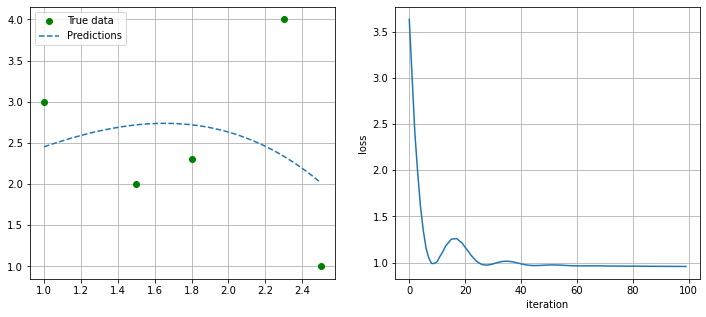

In [39]:
# TODO: try our different polynomial degrees

polynomial_degree = 3
model = PolynomialModel(polynomial_degree)
# Use LBFGS for fast convergence, but check valdity of solution. 
# Remember: LBFGS is only an approximate 2nd order optimizer
#optimizer = torch.optim.LBFGS(model.parameters()) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

losses = []
num_iters = 100

train(num_iters, model, optimizer, criterion, x_data, y_data, losses)

plot_progress_polynoial(losses, model, x_data, y_data)


### 3.3.2 Learning Rate Optimization

**Exercise**

Work with polynomial degree = 3.

Apply grid and/or random search over the learning rate of Adam. Do also combined optimization over the second order momentum parameter $\beta_2$ and learning rate.

In [62]:
# TODO: Optimize the learning rate of Adam training a model on the dataset with five points 
# by doing a grid search in an interval with learning rates and finding the optimal learning rate for the fit (lowest loss)

#Search between 0.05 and 1 in steps of 0.05
#lr_vals = np.linspace(0.05,1,20)
lr_vals = np.random.uniform(0.05,1.5,20)

polynomial_degree = 3
model = PolynomialModel(polynomial_degree)
# Use LBFGS for fast convergence, but check valdity of solution. 
# Remember: LBFGS is only an approximate 2nd order optimizer
#optimizer = torch.optim.LBFGS(model.parameters())

#loop over every lr-value
loss_list = []
for i in range(len(lr_vals)):
  #define optimizer for each learning rate and train model
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_vals[i])
  criterion = nn.MSELoss()
  losses = []
  num_iters = 100

  train(num_iters, model, optimizer, criterion, x_data, y_data, losses)

  loss_list.append(losses[-1])

print(f"Minimum loss occured by a learning rate = {lr_vals[np.array(loss_list)==min(loss_list)]} and was {min(loss_list)}")



#plot_progress_polynoial(losses, model, x_data, y_data)




## Parameters before training
linear.weight :  tensor([[-0.0939, -0.1071,  0.1219]])
linear.bias :  tensor([0.0063])
## Parameters after training:
linear.weight :  tensor([[ 0.7016,  0.0958, -0.1393]])
linear.bias :  tensor([1.9271])
## Loss at the end of training = 0.9557750821113586
## Parameters before training
linear.weight :  tensor([[ 0.7016,  0.0958, -0.1393]])
linear.bias :  tensor([1.9271])
## Parameters after training:
linear.weight :  tensor([[ 0.6471,  0.1123, -0.1432]])
linear.bias :  tensor([1.9485])
## Loss at the end of training = 0.9543243646621704
## Parameters before training
linear.weight :  tensor([[ 0.6471,  0.1123, -0.1432]])
linear.bias :  tensor([1.9485])
## Parameters after training:
linear.weight :  tensor([[ 0.6065,  0.1388, -0.1404]])
linear.bias :  tensor([1.9851])
## Loss at the end of training = 0.9587160348892212
## Parameters before training
linear.weight :  tensor([[ 0.6065,  0.1388, -0.1404]])
linear.bias :  tensor([1.9851])
## Parameters after train

### 3.3.3 Learning Rate Scheduling

**Exercise**

Work with polynomial degree = 3.

Apply stepwise decreasing learning rate - in PyTorch [`MultiStepLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR) using the Adam optimizer.



In [80]:
# TODO: try MultiStepLR (See changed train-function for implementation)

polynomial_degree = 3
model = PolynomialModel(polynomial_degree)
# Use LBFGS for fast convergence, but check valdity of solution. 
# Remember: LBFGS is only an approximate 2nd order optimizer
#optimizer = torch.optim.LBFGS(model.parameters()) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

losses = []
num_iters = 100

train(num_iters, model, optimizer, criterion, x_data, y_data, losses,stepwise_lr=True)

plot_progress_polynoial(losses, model, x_data, y_data)




## Parameters before training
linear.weight :  tensor([[0.0278, 0.4961, 0.0455]])
linear.bias :  tensor([0.1755])


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

TypeError: ignored

### 3.3.4 Regularization

**Exercise**

Work with polynomial degree = 5.

Apply L1 and L2 regularization to the weights of the model using the Adam optimizer. 
> Hint: See [this](https://stackoverflow.com/a/66543549) discussion. More precisely, `l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())` and `l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())`

In [ ]:
# TODO: 

